# Data Source: https://www.kaggle.com/sjleshrac/airlines-customer-satisfaction

***

# Initial Data Setup and Filtering

In [ ]:
# imports
import warnings
import scipy.stats
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import *
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.utils import resample
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import explain_weights, permutation_importance
import datetime as dt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from imblearn.datasets import make_imbalance
start=dt.datetime.now()
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.000087


In [47]:
# load data
df = pd.read_csv('Invistico_Airline.csv')

In [48]:
# preview data
print(df.shape)
df.head()

(129880, 23)


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [49]:
# preview data types for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
satisfaction                         129880 non-null object
Gender                               129880 non-null object
Customer Type                        129880 non-null object
Age                                  129880 non-null int64
Type of Travel                       129880 non-null object
Class                                129880 non-null object
Flight Distance                      129880 non-null int64
Seat comfort                         129880 non-null int64
Departure/Arrival time convenient    129880 non-null int64
Food and drink                       129880 non-null int64
Gate location                        129880 non-null int64
Inflight wifi service                129880 non-null int64
Inflight entertainment               129880 non-null int64
Online support                       129880 non-null int64
Ease of Online booking               129880 non-null int64

In [50]:
# rename columns for easier coding
for col in df.columns:
    df.rename(columns={col:col.replace(' ','_')},inplace=True)
    df.rename(columns={col:col.replace('-','_')},inplace=True)
    df.rename(columns={col:col.replace('/','_')},inplace=True)

In [51]:
# new column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
satisfaction                         129880 non-null object
Gender                               129880 non-null object
Customer_Type                        129880 non-null object
Age                                  129880 non-null int64
Type_of_Travel                       129880 non-null object
Class                                129880 non-null object
Flight_Distance                      129880 non-null int64
Seat_comfort                         129880 non-null int64
Departure/Arrival_time_convenient    129880 non-null int64
Food_and_drink                       129880 non-null int64
Gate_location                        129880 non-null int64
Inflight_wifi_service                129880 non-null int64
Inflight_entertainment               129880 non-null int64
Online_support                       129880 non-null int64
Ease_of_Online_booking               129880 non-null int64

In [52]:
# rename columns for easier coding
for col in df.columns:
    df.rename(columns={col:col.replace(' ','_')},inplace=True)
    df.rename(columns={col:col.replace('-','_')},inplace=True)
    df.rename(columns={col:col.replace('/','_')},inplace=True)

In [53]:
# map satisfaction as binary integer
df.satisfaction = df.satisfaction.map(lambda x: {'satisfied':1,'dissatisfied':0}[x])

In [54]:
# how much data is lost by removing all null values indiscriminately?
f'data lost: {(len(df)-len(df.dropna()))/len(df):.2%} of total data'

'data lost: 0.30% of total data'

In [55]:
# create a new data frame where Arrival Delay in Minutes is unknown for further investigation
unknown_arrival_delay = df[df['Arrival_Delay_in_Minutes'].isna()==True]

In [56]:
# remove data with null values
df.dropna(inplace=True)

In [57]:
# reset index to account for dropped values and remove added column
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [58]:
df.head()

,satisfaction,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,1,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [59]:
# map gender for male and female
df.Gender = df.Gender.map(lambda x: {'Male':0,'Female':1}[x])

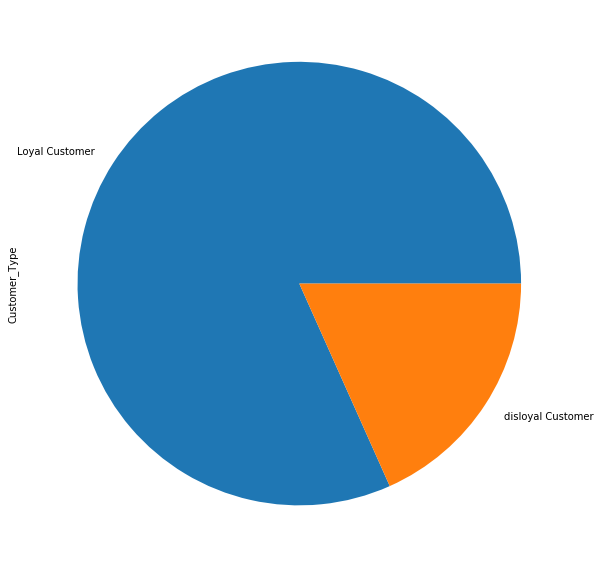

In [60]:
# unique values for customer type
df.Customer_Type.value_counts().plot(kind='pie',figsize=(15,8))
plt.tight_layout()
plt.show()

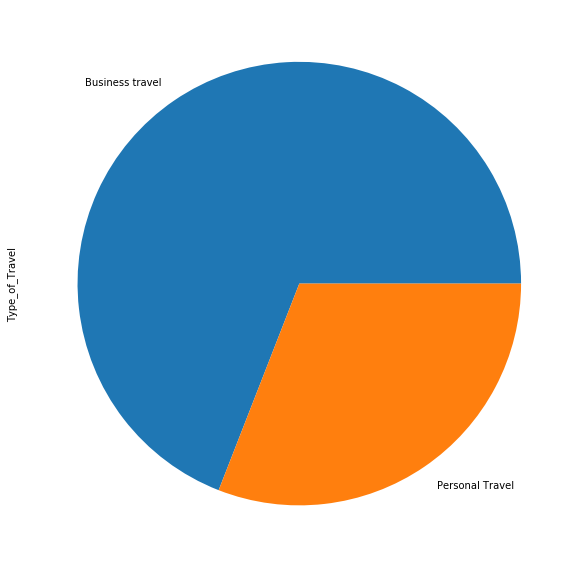

In [61]:
# unique values for travel type
df.Type_of_Travel.value_counts().plot(kind='pie',figsize=(15,8))
plt.tight_layout()
plt.show()

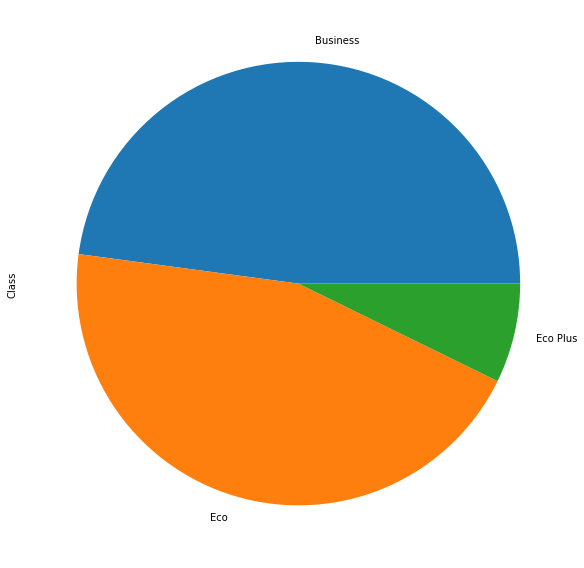

In [62]:
# unique values for class
df.Class.value_counts().plot(kind='pie',figsize=(15,8))
plt.tight_layout()
plt.show()

In [63]:
# export data for EDA
#df.to_csv('EDA_data.csv')

# Feature engineering

#### Feature scaling, transformations, outlier filtration, etc

In [67]:
# create new dataframe for zscores of each numerical variable value
df_outliers = df.copy()

for col in df_outliers.select_dtypes(exclude='O').drop('satisfaction',axis=1).columns:
    df_outliers[col]=stats.zscore(df_outliers[col])

In [68]:
# filter out categorical data
df_outliers=df_outliers.select_dtypes(exclude='O')

In [69]:
df_outliers.head()

,satisfaction,Gender,Age,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,Gate_location,Inflight_wifi_service,Inflight_entertainment,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,1,0.985288,1.691495,-1.671090,-2.037943,-1.958042,-1.975658,-0.758380,-0.947223,0.457857,-1.163548,-0.36166,-0.366038,-2.698079,-0.601358,1.316301,-0.612919,-1.041526,-0.386036,-0.392329
1,1,-1.014931,0.500825,0.470348,-2.037943,-1.958042,-1.975658,0.007368,-2.463800,-1.028077,-1.163548,-0.36166,0.420898,0.397718,0.263333,-1.063601,-0.612919,-1.041526,7.786328,7.536854
2,1,0.985288,-1.615922,0.152882,-2.037943,-1.958042,-1.975658,0.007368,-0.947223,-2.514012,-1.163548,-1.12761,-0.366038,-0.376231,0.263333,0.523000,0.255379,-1.041526,-0.386036,-0.392329
3,1,0.985288,1.360753,-1.322461,-2.037943,-1.958042,-1.975658,0.007368,-0.188935,0.457857,-0.398040,-1.89356,-1.939912,-2.698079,-2.330739,0.523000,-2.349514,-0.271477,-0.386036,-0.392329
4,1,0.985288,2.022237,-1.584420,-2.037943,-1.958042,-1.975658,0.007368,0.569353,-0.285110,0.367469,-1.12761,-1.152975,-2.698079,-1.466048,0.523000,-1.481216,1.268621,-0.386036,-0.392329


In [70]:
# check how much data is maintained under filtering out data more than 2 standard deviations away
df_outliers[df_outliers<2].dropna().shape[0]/df_outliers.shape[0]

0.9191579077436345

In [71]:
# filter out 2 standard deviation difference outliers
df_outliers=df_outliers[df_outliers<2].dropna()

In [72]:
# cut dataframe into one column to make things less complicated now that index is deterimned
df_outliers=df_outliers.iloc[:,0:1]

In [76]:
# join original data on index of outlier-filtered data
df=df.join(df_outliers,lsuffix='extra').dropna()

In [78]:
# drop the added column
df.drop('satisfactionextra',axis=1,inplace=True)

In [82]:
df.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,Gate_location,...,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,3,3,0,3,5,3,2,0,0.0,1.0
1,1,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,3,3,4,4,4,2,0,0.0,1.0
2,1,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,1,1,0,1,4,1,3,0,0.0,1.0
3,0,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,5,4,5,5,4,2,0,0.0,1.0
4,1,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,0,5,5,5,3,17,15.0,1.0


In [79]:
# reset the index
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [81]:
# preview new data
print(df.shape)
df.head()

(119019, 23)


,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,Gate_location,...,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,3,3,0,3,5,3,2,0,0.0,1.0
1,1,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,3,3,4,4,4,2,0,0.0,1.0
2,1,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,1,1,0,1,4,1,3,0,0.0,1.0
3,0,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,5,4,5,5,4,2,0,0.0,1.0
4,1,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,0,5,5,5,3,17,15.0,1.0
